# 스트린트 미션 05

#1. 데이터 소개 및 프로젝트 목표

- train: 손상된 문서(모델 훈련용)  
- train_cleaned: 손상된 문서의 원본(모델 훈련용)  
- test: 손상된 문서(모델 테스트용)  

## 1-1 프로젝트 목표

- **분석 과정과 결과:**
데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
다양한 이미지 처리 기법을 적용하고, 문서 복원 모델을 구축하며 실험한 방법과 결과를 코드로 작성해 주세요.
- **마크다운을 활용한 설명:**
코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
분석 과정과 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.
- **모델 정확도 제출:**
제공된 데이터셋의 테스트 파일을 사용하여 각 모델로 예측값을 생성한 후, 제공된 정답값과 비교하여 모델의 정확도를 측정합니다.
RMSE, PSNR 등의 지표를 활용할 수 있으며, 이를 통해 각 모델의 성능을 비교하고, 최종적으로 가장 성능이 좋은 모델을 선택하세요.
테스트 데이터에 대한 정확도 측정 결과를 제출 파일에 포함하여 제출해 주세요.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import TensorDataset

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1-2 데이터 로드

In [ ]:
# 폴더 경로 설정
from google.colab import drive
drive.mount('/content/drive')
train_dir = "/content/drive/MyDrive/train/train"
train_cleaned_dir = "/content/drive/MyDrive/train_cleaned/train_cleaned"
test_dir = "/content/drive/MyDrive/test/test"

# 이미지 파일 읽기 함수
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):  # PNG 파일만 가져오기
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)  # OpenCV로 이미지를 읽음 (BGR 형식)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
            images.append(img)
    return images

# 이미지 불러오기 (array 형태)
train_images = load_images_from_folder(train_dir)
train_cleaned_images = load_images_from_folder(train_cleaned_dir)
test_images = load_images_from_folder(test_dir)

# 결과 출력
print(f"Train: {len(train_images)}")
print(f"Train Cleaned: {len(train_cleaned_images)}")
print(f"Test: {len(test_images)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: 144
Train Cleaned: 144
Test: 72


In [ ]:
print(type(train_images))
print(type(train_images[0]))

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
# H , W , 3(RGB)
train_images[0].shape

(420, 540, 3)

# 2. 전처리

## 2-1 이미지 크기 확인 및 전처리 방법 선택

In [ ]:
# 각 데이터셋의 이미지 크기 추출
train_sizes = [img.shape[:2] for img in train_images]  # train 이미지의 크기 (height, width)
train_cleaned_sizes = [img.shape[:2] for img in train_cleaned_images]  # train_cleaned 이미지의 크기
test_sizes = [img.shape[:2] for img in test_images]  # test 이미지의 크기

# 유니크한 이미지 크기 계산
train_unique_sizes = np.unique(train_sizes, axis=0)  # train 이미지의 유니크 크기
train_cleaned_unique_sizes = np.unique(train_cleaned_sizes, axis=0)  # train_cleaned 유니크 크기
test_unique_sizes = np.unique(test_sizes, axis=0)  # test 유니크 크기

# 결과 출력
print("Unique sizes in train:\n", train_unique_sizes)
print("Unique sizes in train_cleaned:\n", train_cleaned_unique_sizes)
print("Unique sizes in test:\n", test_unique_sizes)

Unique sizes in train:
 [[258 540]
 [420 540]]
Unique sizes in train_cleaned:
 [[258 540]
 [420 540]]
Unique sizes in test:
 [[258 540]
 [420 540]]


- 258 * 540 / 420*540 두개의 유니크한 이미지 존재  

- 이에 따른 다양한 전처리 방법 :
 - 방법 1. 258 * 540 위아래로 패딩  
 - 방법 2. 해상도 그룹별 모델 분리  
 - 방법 3. resize  
 - 방법 4 . Adaptive Pooling / Adaptive Resize  
(입력크기에 관계없이 특정 크기로 feature map)  
 - 방법 5. FCN  Fully Convolutional Network  
(완전히 Conv만으로 구성된 모델은 입력 크기 자유롭다!)  
 - 방법 6. Spatial Transformer Networks (STN)  
(이미지 내에서 자동으로 관심 영역을 학습해서 정렬하는 모듈)  
 - 방법 7. Vision Transformer (ViT) 기반 모델  
(이미지 크기에 덜 민감한 최신 모델들 Patch 단위로 이미지를 쪼개어 처리 → 패딩이나 리사이즈에 덜 민감)  

---
-> 방법 1을 선택하고 모델링 시작

## 2-2 padding

H : 258 이미지 위아래에 패딩값을 줘서 420으로만든다  
패딩의 색상은 흰색으로 한다

In [ ]:
# 이미지의 크기를 가운데 정렬로 Padding
class PadToSize:
    def __init__(self, target_size):
        self.target_size = target_size  # (높이, 너비)

    def __call__(self, img):
        # 텐서 크기 가져오기 (C, H, W 형식)
        _, height, width = img.shape
        target_height, target_width = self.target_size

        # 패딩 계산
        pad_top = (target_height - height) // 2
        pad_bottom = target_height - height - pad_top
        pad_left = (target_width - width) // 2
        pad_right = target_width - width - pad_left

        # 패딩 적용
        # TF = torchvision.transforms.fuctional
        # 문서 배경이 흰색에 가깝기 때문에 흰색 여백 추가
        return TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=255)

## 2-3 RBG 이미지 -> Grayscale(흑백) 변환
주어진 이미지는 문서 형식으로, 흰색 배경에 검은색 또는 어두운 색의 텍스트가 포함되어 있으며, 그위에 다양한 노이즈가 추가된 형태입니다.

문서 복원의 목적상 색상 정보는 중요하지 않고, 글자의 구조와 명암 대비가 핵심 정보이기 때문에, 입력 이미지를 Grayscale로 변환하여 모델이 구조적인 정보에 집중하도록 처리

In [ ]:
class Grayscale:  # 텐서형 이미지 입력 받아서 흑백 텐서형 이미지로 환
    def __call__(self, img):
        """
        RGB 이미지를 그레이스케일로 변환하는 클래스
        :param img: 입력 이미지 (PIL 또는 Tensor)
        :return: 그레이스케일 변환된 이미지 (Tensor)
        """
        # Tensor -> PIL 이미지로 변환
        pil_img = TF.to_pil_image(img) if isinstance(img, torch.Tensor) else img

        # 그레이스케일 변환
        grayscale_img = pil_img.convert("L")  # RGB -> Grayscale

        # PIL -> Tensor 변환
        return TF.to_tensor(grayscale_img)

# R, G B를 평균 내거나, 가중 평균을 이용한 변환도 가능

## 2-4 image_data -> Dataset 변환

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.image_files = images
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx): # __getitem__()이 호출되는 순간에만 transform이 적용

        img = self.image_files[idx]

        # numpy -> PIL 변환 + RGB
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img

In [ ]:
# 동일 인덱스의 원본 이미지와 정답(노이즈 제거된 이미지)을 페어로 묶어
# 모델의 입력-정답 쌍으로 활용할 수 있도록 구성한 Dataset 클래스입니다.
# 학습 시, 해당 쌍을 기반으로 loss 계산이 용이하게 됩니다.

class PairedImageDataset(Dataset):
    def __init__(self, train_images, train_cleaned_images, transform=None):
        self.train_files = train_images
        self.cleaned_files = train_cleaned_images
        self.transform = transform

    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):

        # 원본 이미지
        train_img = self.train_files[idx]
        cleaned_img = self.cleaned_files[idx]

        if isinstance(train_img, np.ndarray):
            train_img = Image.fromarray(train_img).convert("RGB")
        if isinstance(cleaned_img, np.ndarray):
            claned_img = Image.fromarray(cleaned_img).convert("RGB")

        if self.transform:
            train_img = self.transform(train_img)
            cleaned_img = self.transform(cleaned_img)

        paired_img = (train_img, cleaned_img)

        return paired_img

In [ ]:
transforms = v2.Compose(
    [
        v2.ToImage(),    # PIL or ndarray → tv_tensors.Image로 변환
        PadToSize((420, 540)),  # 이미지 중심 기준으로 (420, 540) 크기 맞게 padding
        Grayscale(),   # RGB → Grayscale (1채널 흑백 이미지)
        v2.ToDtype(dtype=torch.float32, scale=True)# # float32로 변환 + [0, 1] 정규화
        #v2.Normalize(mean=[0.286], std=[0.353])  #  정규화 추가
    ]
)

In [ ]:
# images -> dataset

train_dataset = ImageDataset(train_images, transforms)
test_dataset = ImageDataset(test_images, transforms)
train_cleaned_dataset = ImageDataset(train_cleaned_images, transforms)
paired_dataset = PairedImageDataset(train_images, train_cleaned_images, transform=transforms)

In [ ]:
## 입력 데이터의 평균과 표준 편차 구하기

def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    mean = 0.0
    std = 0.0
    total = 0

    for images in loader:
        # PairedDataset이라면 이미지만 꺼내기
        if isinstance(images, (list, tuple)):
            images = images[0]  # 복원 전 이미지만 선택

        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_samples

    mean /= total
    std /= total
    return mean, std

In [ ]:
train_dataset[0].shape

torch.Size([1, 420, 540])

In [ ]:
len(paired_dataset)

144

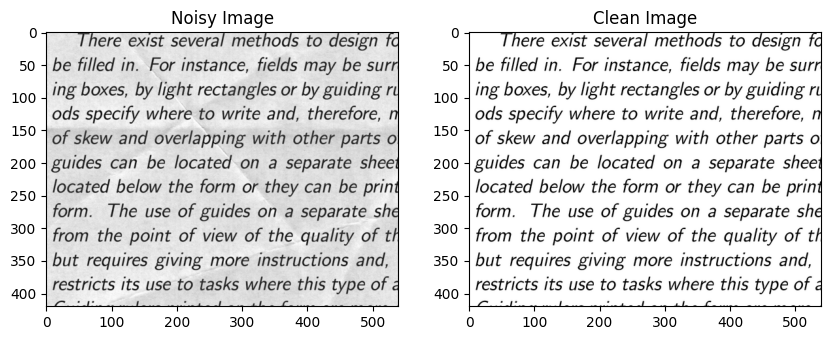

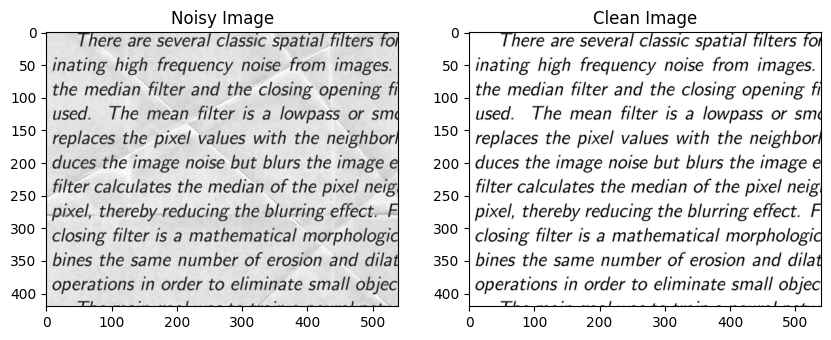

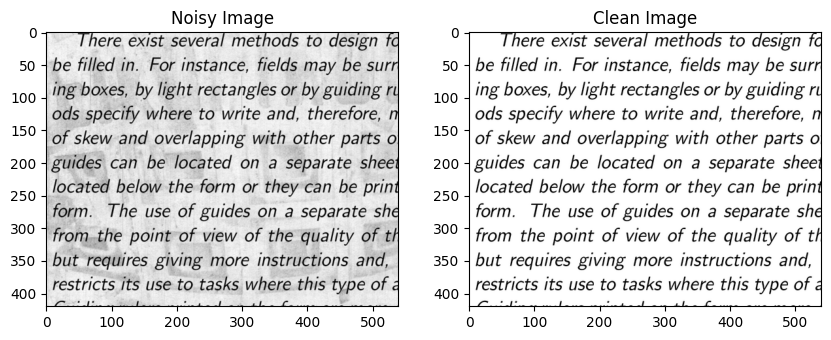

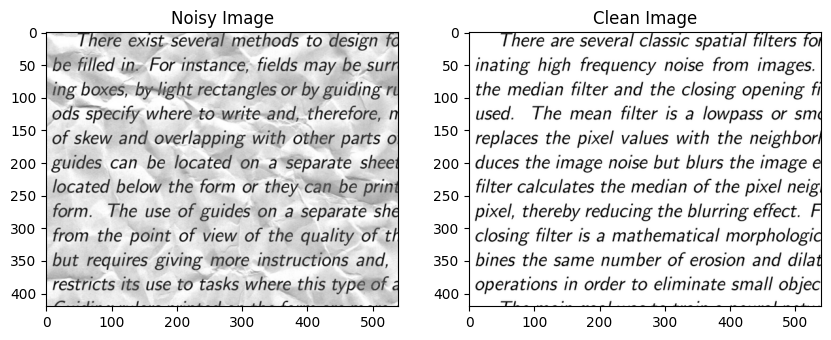

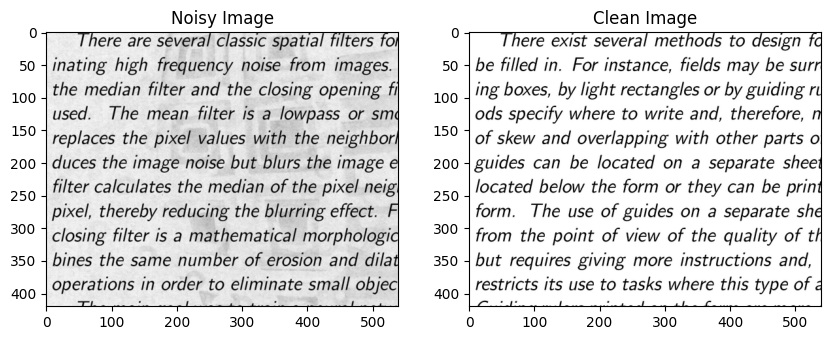

In [ ]:
# paired_dataset에 이미지가 잘 들어갔는지 확인

noisy, clean = paired_dataset[0]
for num in range(5):
    noisy, clean = paired_dataset[num]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(noisy.permute(1, 2, 0), cmap='gray')
    ax[0].set_title('Noisy Image')
    ax[1].imshow(clean.permute(1, 2, 0), cmap='gray')
    ax[1].set_title('Clean Image')
    plt.show()

#3. Dataset -> DataLoader
batch_size = 8

In [ ]:
# DataLoader 생성

paired_loader = DataLoader(paired_dataset, batch_size=8, shuffle=True)  # shuffle=True로 배치를 섞을 수 있음
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
train_cleaned_loader = DataLoader(train_cleaned_dataset, batch_size=8, shuffle=False)

torch.Size([8, 1, 420, 540])

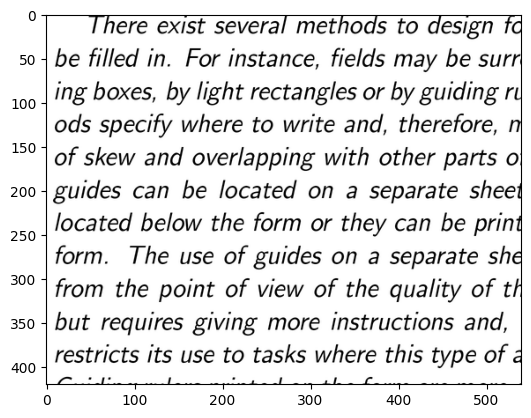

In [ ]:
# DataLoader에 이미지가 잘 들어갔는지 확인

img = next(iter(train_cleaned_loader))
plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
img.shape

# 4. Model

## 4-1 모델 평가에 활용할 지표
loss / rmse / psnr / ssim

In [ ]:
# PSNR (Peak Signal-to-Noise Ratio)
# PSNR은 원본 이미지 대비 복원 이미지가 얼마나 깨끗한지를 데시벨(dB) 단위로 나타낸 지표

def compute_psnr(output, target, max_pixel_value=1.0):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(max_pixel_value) - 10 * math.log10(mse.item())
    return psnr

# ✅ PSNR 해석 기준

# PSNR (dB)	품질 수준
# > 40 dB	거의 완벽한 복원 (거의 원본 수준)
# 30~40 dB	매우 좋은 복원
# 20~30 dB	중간 수준 복원 (실용 가능)
# < 20 dB	복원 품질 낮음

In [ ]:
# SSIM
# 두 이미지가 얼마나 비슷한지 평가하는 척도 / 단순한 픽셀 차이가 아니라, 구조, 명암, 밝기 같은
# "사람 눈에 자연스럽게 보이는 특징"을 기준으로 비교

def compute_ssim(img1, img2):
    # img1, img2는 torch.Tensor (1, H, W) or (H, W)

    if isinstance(img1, torch.Tensor):
        img1 = img1.detach().cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.detach().cpu().numpy()

    # 배치나 채널 차원이 있으면 squeeze
    img1 = np.squeeze(img1)
    img2 = np.squeeze(img2)

    return ssim(img1, img2, data_range=img1.max() - img1.min())

In [ ]:
# RMSE

def compute_rmse(pred, target):
    """
    Root Mean Squared Error 계산
    :param pred: 모델의 출력 (Tensor)
    :param target: 정답 이미지 (Tensor)
    :return: RMSE 값 (float)
    """
    return torch.sqrt(torch.mean((pred - target) ** 2)).item()

## 4-2 이미지 복원 모델에 사용되는 주요 레이어 정리



### 🔸 `nn.Conv2d`
2차원 합성곱 층  
이미지의 공간적 특징(엣지, 텍스처 등)을 추출

---

### 🔸 `nn.ReLU`
비선형성을 부여하여 모델이 복잡한 패턴을 학습할 수 있도록 함

---

### 🔸 `nn.Sigmoid()`
출력 정규화 (0 ~ 1)  
이미지 복원에서는 마지막에 `Sigmoid()` 또는 `Tanh()`를 써서 출력값을 이미지처럼 제한된 값으로 만듦

---

### 🔸 `nn.Tanh()`
출력 범위: -1 ~ 1  
`Sigmoid()`보다 gradient saturation이 덜해서 더 자주 쓰이기도 함  
데이터가 `[-1, 1]` 범위로 normalize되어 있다면 더 적합

---

### 🔸 `nn.BatchNorm2d`
배치 정규화 (Batch Normalization)  
학습을 안정화하고 빠르게 만들어주는 층  
특히 깊은 네트워크에서 gradient vanishing/explosion 문제를 줄임

---

### 🔸 `nn.ConvTranspose2d`
주로 이미지 복원에서 해상도 복원(업샘플링)에 사용  
`UNet`, `Autoencoder` 구조에서 **Decoder** 부분에 자주 사용됨

---

### 🔸 `nn.Upsample`
단순한 업샘플링 (interpolation 방식)  
`bilinear`, `nearest` 등 다양한 보간 방법 사용 가능  
계산량 적고 깔끔한 업샘플링

---

### 🔸 `nn.MaxPool2d` / `nn.AvgPool2d`
특징 압축 (Pooling)

- `Max`: 특징을 뽑아냄  
- `Avg`: 부드럽게 축소  
이미지 복원에선 자주 사용되진 않지만, **Encoder 부분**에서 사용될 수 있음


---

### 🔸 `Residual Block`

- Residual Block은 입력과 "차이"만 학습하므로,
- 자국이나 노이즈처럼 '불필요한 부분'을 제거하는 데 효과적입니다.
- 일반적인 Conv는 전체 이미지를 통째로 다시 예측해야 함
- Residual은 기존 입력에서 "뭘 빼야 할지"만 학습 → 노이즈 같은 지워야 할 요소만 집중해서 학습 가능

## 4-3 초기 model 생성 및 학습
- model = AutoEncode

In [ ]:
# AutoEncoder 기반 이미지 복원 모델
# 입력: (B, 1, 420, 540) 크기의 Grayscale 이미지
# 인코더 : 입력 이미지의 공간 크기는 유지하면서 채널 수를 늘려 특징 추출 (저수준 특징 추출)
#          -> 채널 수를 2배로 늘리고 stride를 늘려서 이미지 크기를 절반으로 만듬 ( 공간 정보를 압축하여 고수준 의미정보 학습)
# 디코더 : 인코더에서 압축된 특징 맵을 다시 원래 이미지 크기로 복원합니다. -> Conv2d는 최종 채널 수를 1로 줄입니다.
# 출력: 원본과 동일한 크기의 복원 이미지

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(  # ➜ (16, 1, 420, 540)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # ➜ (B, 32, 420, 540))
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),   # ➜ (B, 64, 210, 270)
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # ➜ (B, 32, 420, 540)
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # ➜ (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

In [ ]:
epochs = 40

loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0558, rmse : 0.2362 , psnr : 12.5348, ssim : 0.1155
Epoch [2/40], Loss: 0.0566, rmse : 0.2379 , psnr : 12.4718, ssim : 0.4230
Epoch [3/40], Loss: 0.0406, rmse : 0.2014 , psnr : 13.9168, ssim : 0.4948
Epoch [4/40], Loss: 0.0272, rmse : 0.1651 , psnr : 15.6475, ssim : 0.6944
Epoch [5/40], Loss: 0.0280, rmse : 0.1672 , psnr : 15.5362, ssim : 0.7211
Epoch [6/40], Loss: 0.0060, rmse : 0.0775 , psnr : 22.2189, ssim : 0.9343
Epoch [7/40], Loss: 0.0145, rmse : 0.1204 , psnr : 18.3867, ssim : 0.8588
Epoch [8/40], Loss: 0.0039, rmse : 0.0626 , psnr : 24.0697, ssim : 0.9507
Epoch [9/40], Loss: 0.0137, rmse : 0.1170 , psnr : 18.6336, ssim : 0.9257
Epoch [10/40], Loss: 0.0320, rmse : 0.1788 , psnr : 14.9530, ssim : 0.7961
Epoch [11/40], Loss: 0.0220, rmse : 0.1483 , psnr : 16.5750, ssim : 0.7277
Epoch [12/40], Loss: 0.0034, rmse : 0.0587 , psnr : 24.6259, ssim : 0.9563
Epoch [13/40], Loss: 0.0026, rmse : 0.0507 , psnr : 25.8957, ssim : 0.9753
Epoch [14/40], Loss: 0.0024, rmse 

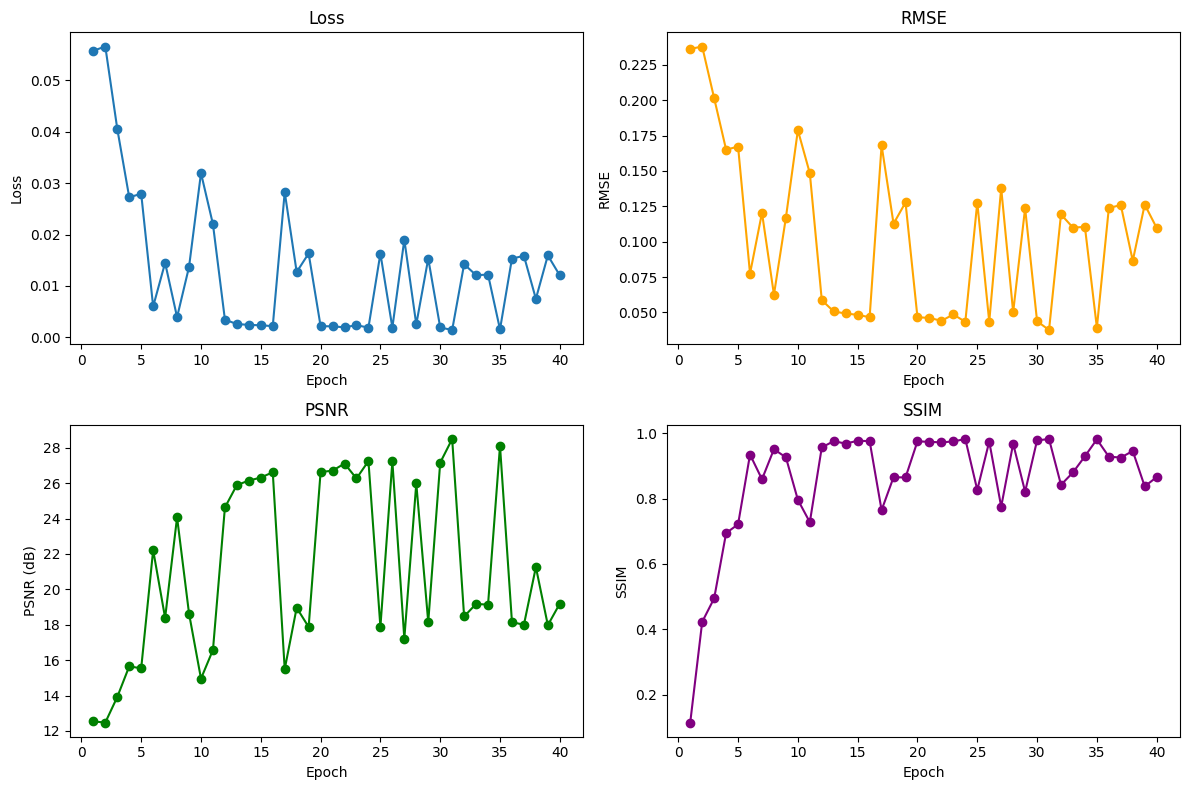

In [ ]:
# 시각화

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_list, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# RMSE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, rmse_list, marker='o', color='orange')
plt.title("RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

# PSNR
plt.subplot(2, 2, 3)
plt.plot(epochs_range, psnr_list, marker='o', color='green')
plt.title("PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")

# SSIM
plt.subplot(2, 2, 4)
plt.plot(epochs_range, ssim_list, marker='o', color='purple')
plt.title("SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()

- 학습이 진행 될수록 Loss 및 rmse 감소 , psnr 및 ssim 상승
- **Epoch [31/40], Loss: 0.0014, rmse : 0.0376 , psnr : 28.4957, ssim : 0.9818**
- 1~6 epoch	⬆️ 성능 꾸준히 향상 (학습 초기 구간)
- 7~40 epoch	✅ 최고 성능 도달 (성능 소폭 상승 , 출렁이는 구간 발생)

In [ ]:
# 테스트 데이터로 모델 성능 확인

model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        outputs = model(images) # 출력
        break

def visualize_images_and_outputs(images, outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """
    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))  # num_images 행, 2열

    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, outputs)

- test 결과가 나쁘지 않음
- 특히 배경에 전체적으로 얼룩이 있는 이미지의 경우 얼룩 제거가 잘 되었고, 부분적으로 얼룩이 진하게 있는 이미지의 경우 얼룩의 자국이 일부 남아 있으나 글자가 잘 복원되어 읽는데 지장이 없음

- 이미지 1, 6, 10, 13, 15 에서 조금 남아 있는 잔상을 제거할 방법을 search

## 4-4 model 보완 - AutoEncoder2
- Decocer 에서 Conv2d -> ConvTranspose2d  
- model2 = AutoEncoder2

In [ ]:
# 복원 방식의 구조적인 변화
# 기존 모델에서는 디코더의 마지막 복원 단계에 일반 Conv2d 레이어를 사용하여, 업샘플링된 feature map을 픽셀 수준으로 정제하는 방식
# 하지만 이번 구조에서는 ConvTranspose2d를 추가로 사용하여 마지막 출력까지 업샘플링 방식으로 복원되도록 변경
# 이로 인해, 출력 이미지가 보다 부드럽고, 공간적 구조를 더 잘 살리는 경향을 보이며,
# 특히 경계선, 텍스트 윤곽 등에서 더 자연스러운 결과를 기대

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(  # ➜ (16, 1, 420, 540)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # ➜ (B, 32, 420, 540))
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),   # ➜ (B, 64, 210, 270)
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # ➜ (B, 32, 420, 540)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # ➜ (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model2 = AutoEncoder2().to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
loss = nn.MSELoss()

In [ ]:
epochs = 40

loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model2(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0479, rmse : 0.2188 , psnr : 13.1998, ssim : 0.2394
Epoch [2/40], Loss: 0.0201, rmse : 0.1419 , psnr : 16.9605, ssim : 0.7970
Epoch [3/40], Loss: 0.0091, rmse : 0.0956 , psnr : 20.3878, ssim : 0.8962
Epoch [4/40], Loss: 0.0138, rmse : 0.1175 , psnr : 18.5957, ssim : 0.8580
Epoch [5/40], Loss: 0.0028, rmse : 0.0530 , psnr : 25.5086, ssim : 0.9649
Epoch [6/40], Loss: 0.0171, rmse : 0.1306 , psnr : 17.6819, ssim : 0.8563
Epoch [7/40], Loss: 0.0029, rmse : 0.0541 , psnr : 25.3296, ssim : 0.9667
Epoch [8/40], Loss: 0.0161, rmse : 0.1268 , psnr : 17.9361, ssim : 0.8094
Epoch [9/40], Loss: 0.0018, rmse : 0.0419 , psnr : 27.5531, ssim : 0.9806
Epoch [10/40], Loss: 0.0172, rmse : 0.1313 , psnr : 17.6369, ssim : 0.8047
Epoch [11/40], Loss: 0.0159, rmse : 0.1260 , psnr : 17.9896, ssim : 0.8657
Epoch [12/40], Loss: 0.0015, rmse : 0.0387 , psnr : 28.2414, ssim : 0.9843
Epoch [13/40], Loss: 0.0124, rmse : 0.1113 , psnr : 19.0735, ssim : 0.8784
Epoch [14/40], Loss: 0.0171, rmse 

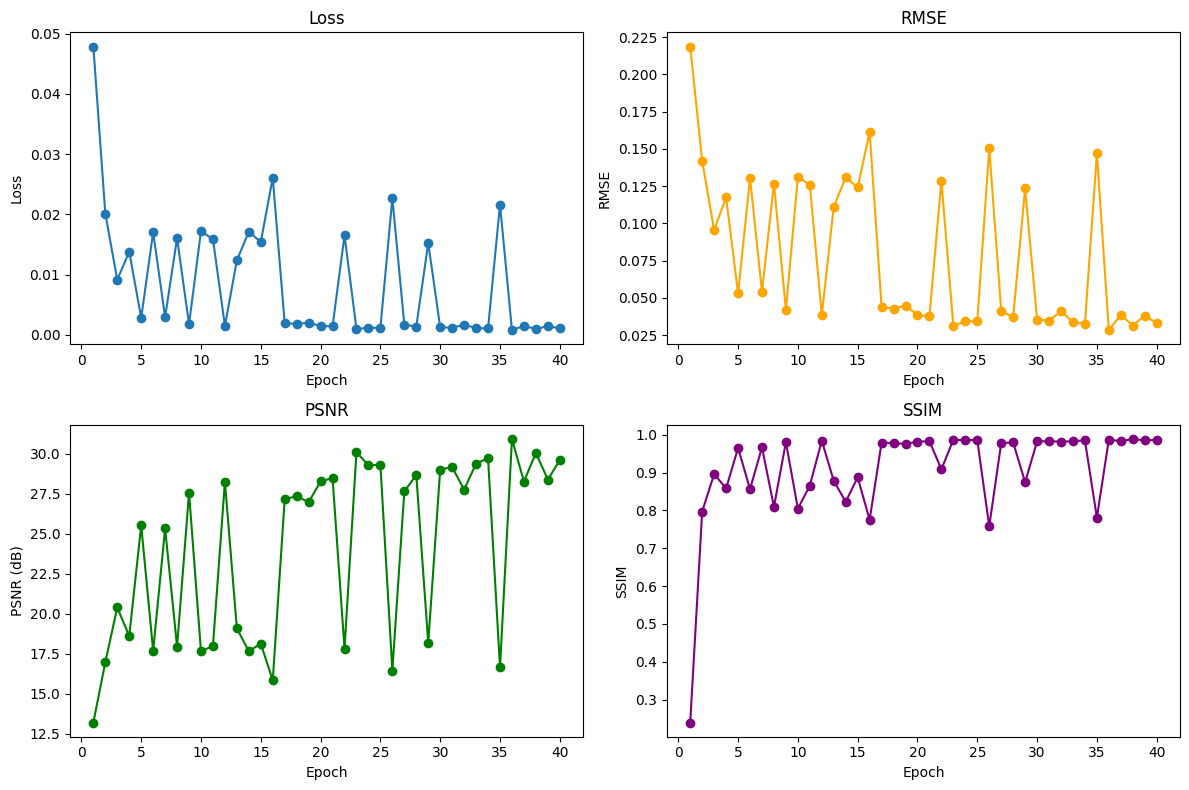

In [ ]:
# 시각화

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_list, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# RMSE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, rmse_list, marker='o', color='orange')
plt.title("RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

# PSNR
plt.subplot(2, 2, 3)
plt.plot(epochs_range, psnr_list, marker='o', color='green')
plt.title("PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")

# SSIM
plt.subplot(2, 2, 4)
plt.plot(epochs_range, ssim_list, marker='o', color='purple')
plt.title("SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()

- **Epoch [36/40], Loss: 0.0008, rmse : 0.0285 , psnr : 30.9060, ssim : 0.9872**

In [ ]:
# 테스트
model2.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model1_outputs = model(images) # 출력
        model2_outputs = model2(images) # 출력
        break



def visualize_images_and_outputs(images, model1_outputs, model2_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original {i + 1}", fontsize=10)
        axes[i, 0].axis('off')


        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(model1_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Model1 Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

        # 세 번째 열: 출력 이미지
        axes[i, 2].imshow(model2_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Model2 Output {i + 1}", fontsize=10)
        axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model1_outputs, model2_outputs)

- model1 보다 model2의 Output 노이즈의 경계선이 옅어지는 경우가 많아짐

## 4-5 model 보완 - AutoEncoder3
- MinPooling 활용 / 노이즈가 글자가 보다 색이 밝기때문에 MinPooling 활용 해보기
- MinPooling Layer 2개 추가
- model3 = AutoEncoder3

In [ ]:
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        return -F.max_pool2d(-x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

In [ ]:
class AutoEncoder3(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 420, 540)
            nn.ReLU(),
            MinPool2d(2),                              # (B, 32, 210, 270)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 210, 270)
            nn.ReLU(),
            MinPool2d(2)                               # (B, 64, 105, 135)
)

          # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 210, 270)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model3 = AutoEncoder3().to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
loss = nn.MSELoss()

In [ ]:
epochs = 40
loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model3.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model3(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0713, rmse : 0.2670 , psnr : 11.4682, ssim : 0.1318
Epoch [2/40], Loss: 0.0641, rmse : 0.2531 , psnr : 11.9342, ssim : 0.0892
Epoch [3/40], Loss: 0.0602, rmse : 0.2454 , psnr : 12.2008, ssim : 0.1571
Epoch [4/40], Loss: 0.0475, rmse : 0.2180 , psnr : 13.2328, ssim : 0.2294
Epoch [5/40], Loss: 0.0541, rmse : 0.2325 , psnr : 12.6703, ssim : 0.2232
Epoch [6/40], Loss: 0.0466, rmse : 0.2158 , psnr : 13.3191, ssim : 0.3669
Epoch [7/40], Loss: 0.0411, rmse : 0.2027 , psnr : 13.8631, ssim : 0.4335
Epoch [8/40], Loss: 0.0323, rmse : 0.1797 , psnr : 14.9103, ssim : 0.5909
Epoch [9/40], Loss: 0.0232, rmse : 0.1524 , psnr : 16.3410, ssim : 0.6739
Epoch [10/40], Loss: 0.0262, rmse : 0.1619 , psnr : 15.8169, ssim : 0.7225
Epoch [11/40], Loss: 0.0194, rmse : 0.1391 , psnr : 17.1321, ssim : 0.7767
Epoch [12/40], Loss: 0.0205, rmse : 0.1432 , psnr : 16.8840, ssim : 0.7956
Epoch [13/40], Loss: 0.0192, rmse : 0.1386 , psnr : 17.1649, ssim : 0.8274
Epoch [14/40], Loss: 0.0172, rmse 

- Epoch [37/40], Loss: 0.0082, rmse : 0.0907 , psnr : 20.8516, ssim : 0.9159

In [ ]:
# 테스트
model3.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model2_outputs = model2(images) # 출력
        model3_outputs = model3(images) # 출력
        break



def visualize_images_and_outputs(images, model2_outputs, model3_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original {i + 1}", fontsize=10)
        axes[i, 0].axis('off')


        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(model2_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Model2 Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

        # 세 번째 열: 출력 이미지
        axes[i, 2].imshow(model3_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 2].set_title(f"MinPooling(2_Layer) Output {i + 1}", fontsize=10)
        axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model2_outputs, model3_outputs)

- 이미지 6, 15 의 경우 노이즈가 개선되긴 했으나 이미지 1, 2  그림에서 글자가 뭉개져서 가독성이 떨어지는 현상 발생

## Minpooling 1개층만 사용

- model3_1 = AutoEncoder3_1

In [ ]:
## MinPool2d Layer 1개 활용

class AutoEncoder3_1(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 420, 540)
            nn.ReLU(),
            # MinPool2d(2), <-- 삭제

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 32, 420, 540)
            nn.ReLU(),
            MinPool2d(2)                                # (B, 64, 210, 270)
)

          # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (B, 32, 210, 270)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),   # (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model3_1 = AutoEncoder3_1().to(device)
optimizer = optim.Adam(model3_1.parameters(), lr=0.001)
loss = nn.MSELoss()

In [ ]:
epochs = 40
loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model3_1.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model3_1(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0677, rmse : 0.2601 , psnr : 11.6965, ssim : 0.1813
Epoch [2/40], Loss: 0.0505, rmse : 0.2247 , psnr : 12.9697, ssim : 0.3209
Epoch [3/40], Loss: 0.0276, rmse : 0.1660 , psnr : 15.5973, ssim : 0.6110
Epoch [4/40], Loss: 0.0161, rmse : 0.1269 , psnr : 17.9308, ssim : 0.8182
Epoch [5/40], Loss: 0.0129, rmse : 0.1134 , psnr : 18.9107, ssim : 0.8613
Epoch [6/40], Loss: 0.0080, rmse : 0.0895 , psnr : 20.9677, ssim : 0.9095
Epoch [7/40], Loss: 0.0177, rmse : 0.1329 , psnr : 17.5282, ssim : 0.8231
Epoch [8/40], Loss: 0.0049, rmse : 0.0698 , psnr : 23.1233, ssim : 0.9485
Epoch [9/40], Loss: 0.0047, rmse : 0.0686 , psnr : 23.2757, ssim : 0.9457
Epoch [10/40], Loss: 0.0042, rmse : 0.0645 , psnr : 23.8110, ssim : 0.9617
Epoch [11/40], Loss: 0.0035, rmse : 0.0590 , psnr : 24.5772, ssim : 0.9673
Epoch [12/40], Loss: 0.0034, rmse : 0.0582 , psnr : 24.6982, ssim : 0.9622
Epoch [13/40], Loss: 0.0171, rmse : 0.1309 , psnr : 17.6627, ssim : 0.8048
Epoch [14/40], Loss: 0.0171, rmse 

- Epoch [38/40], Loss: 0.0018, rmse : 0.0421 , psnr : 27.5127, ssim : 0.9795

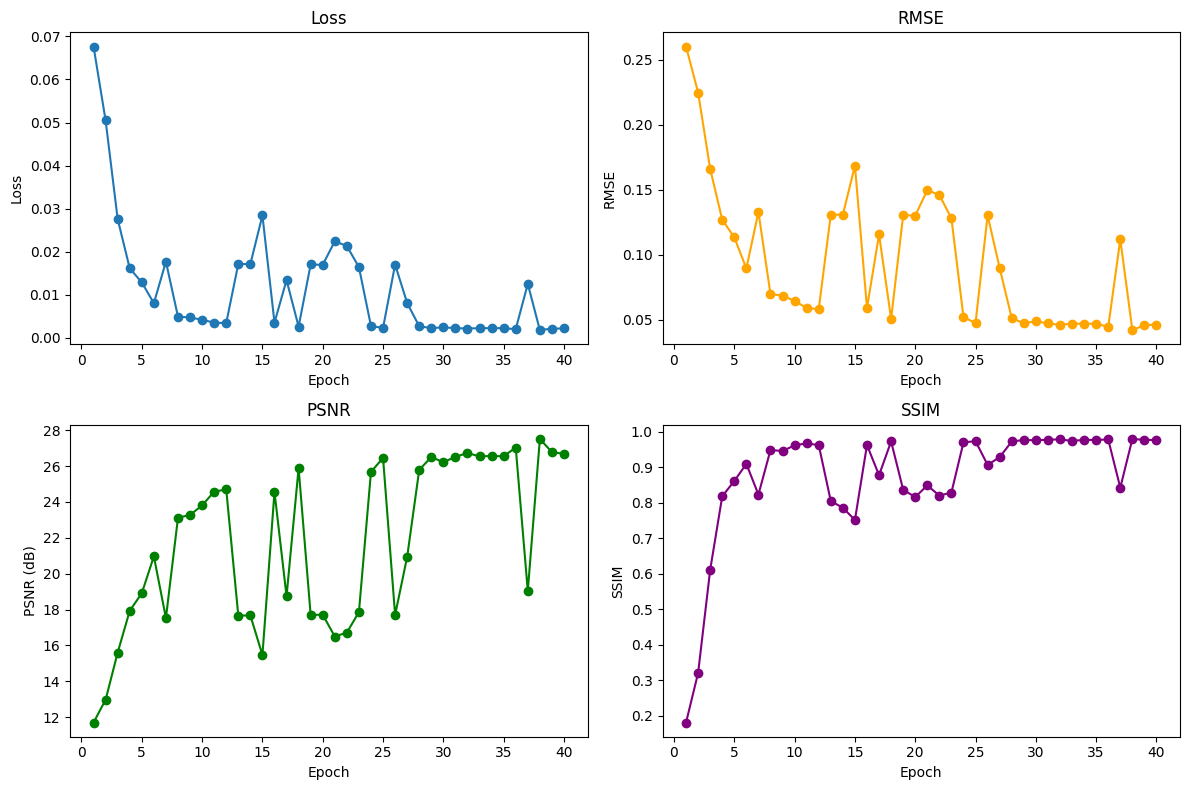

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_list, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# RMSE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, rmse_list, marker='o', color='orange')
plt.title("RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

# PSNR
plt.subplot(2, 2, 3)
plt.plot(epochs_range, psnr_list, marker='o', color='green')
plt.title("PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")

# SSIM
plt.subplot(2, 2, 4)
plt.plot(epochs_range, ssim_list, marker='o', color='purple')
plt.title("SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()

In [ ]:
# 테스트
model3_1.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model3_1_outputs = model3_1(images) # 출력
        model2_outputs = model2(images) # 출력
        model3_outputs = model3(images) # 출력
        break



def visualize_images_and_outputs(images, model2_outputs, model3_outputs, model3_1_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):

        # 두 번째 열: 출력 이미지
        axes[i, 0].imshow(model2_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Model2 Output {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 세 번째 열: 출력 이미지
        axes[i, 1].imshow(model3_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"MinPooling_(2 Layer) Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')


        # 네 번째 열: 출력 이미지
        axes[i, 2].imshow(model3_1_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 2].set_title(f"MinPooling_(1 Layer) Output {i + 1}", fontsize=10)
        axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model2_outputs, model3_outputs, model3_1_outputs)

- encoder 마지막에 MinPooling을 쓴 모델이 MinPooling을 2개쓴 모델보다 더 글자가 잘 복원이 됨
- 뭉개짐 현상이 확실히 개선되어서 더 좋은성능을 보이나 얼룩의 잔상이 다시 진해진 점이 아쉬움
- model2의 최고 Loss 값보단 성능이 떨어지지만 epoch 27부터 비교적 안정적인 성능을 보임
- Minpooling 층이 많아질수록 확실히 배경의 얼룩이 옅어짐을 알수있으나 층이 과도하면 글자가 뭉개짐

## 4-6 특징 추출 Layer 커널 사이즈 변화에 따른 결과값
- kernel size 3 -> 5
- model4 = AutoEncoder4

In [ ]:
class AutoEncoder4(nn.Module):
    def __init__(self):
        super(AutoEncoder4, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(  # ➜ (16, 1, 420, 540)
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),   # ➜ (B, 32, 420, 540))
            MinPool2d(2)       # ➜ (B, 64, 210, 270)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # ➜ (B, 32, 420, 540)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # ➜ (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model4 = AutoEncoder4().to(device)
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss = nn.MSELoss()

epochs = 40

loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model4.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model4(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0701, rmse : 0.2648 , psnr : 11.5430, ssim : 0.1308
Epoch [2/40], Loss: 0.0383, rmse : 0.1956 , psnr : 14.1709, ssim : 0.4770
Epoch [3/40], Loss: 0.0220, rmse : 0.1483 , psnr : 16.5797, ssim : 0.7596
Epoch [4/40], Loss: 0.0146, rmse : 0.1207 , psnr : 18.3652, ssim : 0.8414
Epoch [5/40], Loss: 0.0142, rmse : 0.1191 , psnr : 18.4791, ssim : 0.8735
Epoch [6/40], Loss: 0.0195, rmse : 0.1395 , psnr : 17.1092, ssim : 0.8638
Epoch [7/40], Loss: 0.0148, rmse : 0.1217 , psnr : 18.2969, ssim : 0.8996
Epoch [8/40], Loss: 0.0052, rmse : 0.0723 , psnr : 22.8143, ssim : 0.9459
Epoch [9/40], Loss: 0.0052, rmse : 0.0721 , psnr : 22.8472, ssim : 0.9380
Epoch [10/40], Loss: 0.0047, rmse : 0.0685 , psnr : 23.2814, ssim : 0.9477
Epoch [11/40], Loss: 0.0049, rmse : 0.0703 , psnr : 23.0626, ssim : 0.9514
Epoch [12/40], Loss: 0.0193, rmse : 0.1388 , psnr : 17.1546, ssim : 0.7448
Epoch [13/40], Loss: 0.0168, rmse : 0.1295 , psnr : 17.7523, ssim : 0.8426
Epoch [14/40], Loss: 0.0036, rmse 

- Epoch [37/40], Loss: 0.0018, rmse : 0.0426 , psnr : 27.4067, ssim : 0.9809

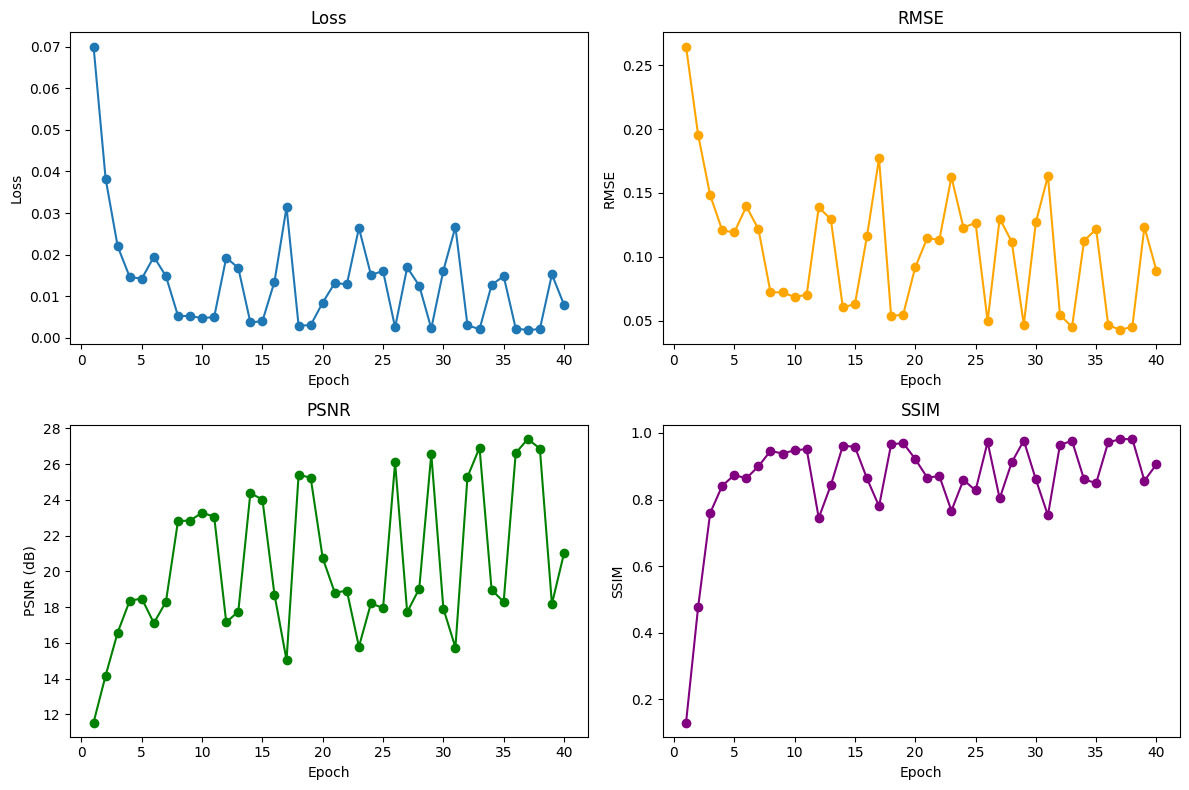

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss_list, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# RMSE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, rmse_list, marker='o', color='orange')
plt.title("RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")

# PSNR
plt.subplot(2, 2, 3)
plt.plot(epochs_range, psnr_list, marker='o', color='green')
plt.title("PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")

# SSIM
plt.subplot(2, 2, 4)
plt.plot(epochs_range, ssim_list, marker='o', color='purple')
plt.title("SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()

In [ ]:
# 테스트
model4.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model3_1_outputs = model3_1(images) # 출력
        model4_outputs = model4(images) # 출력
        break



def visualize_images_and_outputs(images, model2_outputs, model4_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):
        # 첫 번째 열: 원본 이미지
        axes[i, 0].imshow(model3_1_outputs[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"model3_1(kernel = 3) output {i + 1}", fontsize=10)
        axes[i, 0].axis('off')


        # 두 번째 열: 출력 이미지
        axes[i, 1].imshow(model4_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"model4(kernel = 5) output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model3_1_outputs, model4_outputs)

- 커널크기를 키웠더니 미세하게 조금 더 잔상 노이즈가 더 심해짐




### 초기 커널 Size 5 ->7
- model5 = AutoEncoder5

In [ ]:
class AutoEncoder5(nn.Module):
    def __init__(self):
        super(AutoEncoder5, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(  # ➜ (16, 1, 420, 540)
            nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3),   # ➜ (B, 32, 420, 540))
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # ➜ (B, 64, 210, 270)
            nn.ReLU(),
            MinPool2d(2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # ➜ (B, 32, 420, 540)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # ➜ (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model5 = AutoEncoder5().to(device)
optimizer = optim.Adam(model5.parameters(), lr=0.001)
loss = nn.MSELoss()

epochs = 40

loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model5.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model5(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0666, rmse : 0.2580 , psnr : 11.7660, ssim : 0.1136
Epoch [2/40], Loss: 0.0506, rmse : 0.2249 , psnr : 12.9596, ssim : 0.2435
Epoch [3/40], Loss: 0.0350, rmse : 0.1870 , psnr : 14.5650, ssim : 0.5002
Epoch [4/40], Loss: 0.0241, rmse : 0.1552 , psnr : 16.1805, ssim : 0.7534
Epoch [5/40], Loss: 0.0127, rmse : 0.1129 , psnr : 18.9477, ssim : 0.8761
Epoch [6/40], Loss: 0.0183, rmse : 0.1352 , psnr : 17.3818, ssim : 0.8260
Epoch [7/40], Loss: 0.0125, rmse : 0.1118 , psnr : 19.0306, ssim : 0.8700
Epoch [8/40], Loss: 0.0063, rmse : 0.0794 , psnr : 22.0079, ssim : 0.9462
Epoch [9/40], Loss: 0.0057, rmse : 0.0757 , psnr : 22.4235, ssim : 0.9350
Epoch [10/40], Loss: 0.0185, rmse : 0.1362 , psnr : 17.3185, ssim : 0.8290
Epoch [11/40], Loss: 0.0050, rmse : 0.0706 , psnr : 23.0266, ssim : 0.9506
Epoch [12/40], Loss: 0.0171, rmse : 0.1308 , psnr : 17.6701, ssim : 0.8460
Epoch [13/40], Loss: 0.0198, rmse : 0.1406 , psnr : 17.0389, ssim : 0.7859
Epoch [14/40], Loss: 0.0170, rmse 

- Epoch [39/40], Loss: 0.0019, rmse : 0.0433 , psnr : 27.2710, ssim : 0.9798

In [ ]:
# 테스트
model5.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model3_1_outputs = model3_1(images) # 출력
        model4_outputs = model4(images) # 출력
        model5_outputs = model5(images) # 출력
        break



def visualize_images_and_outputs(images, model2_outputs, model4_outputs, model5_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):
        # 첫 번째 열: 원본 이미지

        # 두 번째 열: 출력 이미지
        axes[i, 0].imshow(model3_1_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Model3_1(kernel = 3) Output {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 세 번째 열: 출력 이미지
        axes[i, 1].imshow(model4_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Model4(kernel = 5) Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')

         # 네 번째 열: 출력 이미지
        axes[i, 2].imshow(model5_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Model5(kernel = 7) Output {i + 1}", fontsize=10)
        axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model3_1_outputs, model4_outputs, model5_outputs)

- kernel이 커질수록 노이즈가 더 심해짐해지고, loss값이 안좋아짐을 알수있음
- kernel = 3 으로 선택

## 4-8 latent feature 수 조정
- latnet feature수 64 -> 128
- layer 수 증가
- model_128 = AutoEncoder_128

In [ ]:
# latnet feature수 64 -> 128

class AutoEncoder_128(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, 420, 540)
            nn.ReLU(),
            # MinPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 32, 420, 540)
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B, 32, 420, 540)
            nn.ReLU(),

            MinPool2d(2)                                # (B, 128, 210, 270)
)

          # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # (B, 32, 210, 270)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 210, 270)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),   # (B, 1, 420, 540)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model_128 = AutoEncoder_128().to(device)
optimizer = optim.Adam(model_128.parameters(), lr=0.001)
loss = nn.MSELoss()

epochs = 40

loss_list = []
rmse_list = []
psnr_list = []
ssim_list = []

for epoch in range(epochs):
    model_128.train()
    train_loss = 0.0

    for train_img, train_cleand_img in paired_loader:
        train_img = train_img.to(device)
        train_cleand_img = train_cleand_img.to(device)

        optimizer.zero_grad()
        outputs = model_128(train_img)

        loss_value = loss(outputs, train_cleand_img)
        rmse = compute_rmse(outputs, train_cleand_img)
        psnr = compute_psnr(outputs, train_cleand_img)
        ssim_socre = compute_ssim(outputs, train_cleand_img)

        loss_value.backward()
        optimizer.step()

    # 에폭 단위로 저장
    loss_list.append(loss_value.item())
    rmse_list.append(rmse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_socre)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value.item():.4f}, rmse : {rmse:.4f} , psnr : {psnr:.4f}, ssim : {ssim_socre:.4f}")

Epoch [1/40], Loss: 0.0924, rmse : 0.3040 , psnr : 10.3439, ssim : 0.1092
Epoch [2/40], Loss: 0.0431, rmse : 0.2077 , psnr : 13.6503, ssim : 0.4253
Epoch [3/40], Loss: 0.0234, rmse : 0.1529 , psnr : 16.3098, ssim : 0.7434
Epoch [4/40], Loss: 0.0106, rmse : 0.1030 , psnr : 19.7430, ssim : 0.8930
Epoch [5/40], Loss: 0.0077, rmse : 0.0877 , psnr : 21.1376, ssim : 0.9287
Epoch [6/40], Loss: 0.0052, rmse : 0.0721 , psnr : 22.8438, ssim : 0.9495
Epoch [7/40], Loss: 0.0182, rmse : 0.1351 , psnr : 17.3883, ssim : 0.8878
Epoch [8/40], Loss: 0.0089, rmse : 0.0946 , psnr : 20.4820, ssim : 0.9152
Epoch [9/40], Loss: 0.0031, rmse : 0.0556 , psnr : 25.0982, ssim : 0.9684
Epoch [10/40], Loss: 0.0028, rmse : 0.0531 , psnr : 25.4902, ssim : 0.9729
Epoch [11/40], Loss: 0.0022, rmse : 0.0467 , psnr : 26.6169, ssim : 0.9756
Epoch [12/40], Loss: 0.0159, rmse : 0.1261 , psnr : 17.9857, ssim : 0.8627
Epoch [13/40], Loss: 0.0080, rmse : 0.0897 , psnr : 20.9470, ssim : 0.9203
Epoch [14/40], Loss: 0.0020, rmse 

- Epoch [40/40], Loss: 0.0010, rmse : 0.0315 , psnr : 30.0257, ssim : 0.9894

In [ ]:
model_128.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device) # 원본 이미지
        model3_1_outputs = model3_1(images) # 출력
        model_128_outputs = model_128(images) # 출력
         # 출력
        break



def visualize_images_and_outputs(images, model3_1_outputs, model_128_outputs):
    """
    이미지와 출력 이미지를 열로 구분하여 시각화.
    :param images: 원본 이미지 텐서
    :param outputs: 모델 출력 텐서
    """

    num_images = images.size(0)  # 전체 이미지 개수
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))  # num_images 행, 3열


    for i in range(num_images):

        # 두 번째 열: 출력 이미지
        axes[i, 0].imshow(model3_1_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Model3_1 Output {i + 1}", fontsize=10)
        axes[i, 0].axis('off')

        # 세 번째 열: 출력 이미지
        axes[i, 1].imshow(model_128_outputs[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Model_128 Output {i + 1}", fontsize=10)
        axes[i, 1].axis('off')


    plt.tight_layout()
    plt.show()

visualize_images_and_outputs(images, model3_1_outputs, model_128_outputs)

# 5. 결론 및 소감

- 가장 높은 성능을 보여준 모델은 **model2**였습니다.
  - **Epoch [36/40], Loss: 0.0008, RMSE: 0.0285, PSNR: 30.9060, SSIM: 0.9872**<br>

- **model1** (ConvTranspose2d + Conv2d) vs **model2** (ConvTranspose2d ×2)
  - 여러 번 실험한 결과, **model2**가 **model1**보다 노이즈 잔상의 경계가 옅게 나타났습니다.
  - 평균적으로 **model2**의 Loss 값이 더 낮게 나왔습니다.

- **MinPooling 효과**
  - MinPooling을 2겹 적용했을 때 노이즈 잔상이 확실히 희미해졌습니다.
  - 하지만 MinPooling 층을 많이 쌓을수록 글자가 뭉개지는 현상이 발생했습니다.
  - 가장 적절한 MinPooling 개수는 **1개**였으며, 한 층 적용했을 때 평균적으로 글자가 약간 더 진하게 나타나는 경향을 보였습니다.
  - 노이즈 잔상 측면에서는 model2와 큰 차이는 없었지만, 가독성에서는 미세하게 model2보다 더 좋은 경향을 보였습니다.

- **초기 커널사이즈 영향**
  - 초기 커널사이즈가 커질수록 잔상이 더 짙게 남는 경향이 있었습니다.
  - **커널사이즈 3**일 때 가장 좋은 성능을 보였습니다.

- **Conv2d 레이어 수 및 Latent Feature 수 조정**
  - Conv2d 레이어 수와 Latent Feature 수를 늘린 모델이 기존 모델보다 평균적으로 좋은 성능을 보였습니다.
  - 그러나 레이어 수를 과도하게 늘리면:
    - 연산 속도가 확연히 느려졌고,
    - 글자가 점점 희미해지는 현상이 발생했습니다.
  - 이는 **기울기 소실 문제** 때문으로 추정됩니다.
    - 기울기 소실을 막으며 Conv2d 층을 효과적으로 늘릴 수 있었다면, 더 안정적이고 성능 좋은 모델을 만들 수 있었을 것으로 생각합니다.

## 소감

- 처음 실험에서는 **model3_1**이 **model2**보다 글자가 조금 더 진하게 표현되어 가독성이 더 좋아보였습니다.
- 이에 따라 이후 실험에서는 초기 Kernel 사이즈 비교, Latent Feature 수 / Conv2d 층수 증가 실험을 MinPooling을 포함한 모델로 진행했습니다.
- 그러나 런타임이 끊긴 후 재실행한 실험에서는 **model2**가 다시 가장 좋은 결과(Loss 0.0008)를 기록하였습니다.
- 평균과 표준편차를 이용한 **정규화(Normalization)**를 적용하지 못했고, 실험 시 **Seed 고정**을 하지 못해 재현성 확보에 아쉬움이 남았습니다.

- 전체적으로 **model2**가 가장 높은 성능을 기록했지만, 일관성 있는 안정적인 성능을 보이진 못했습니다. 향후에는 이미지별로 최적은 Latent Feature 수를 탐색하고, 기울기 소실 문제를 해결하면서 Conv2d 레이러를 효과적으로 늘리는 동시에, 적절한 Min/Max Pooling을 조합하여 보다 견고한 Autoencoder 모델을 만드는 것이 중요하다고 생각합니다


[멘토]
전체적으로 깔끔한 엔드-투-엔드 파이프라인과 꼼꼼한 실험 기록이 정말 인상적이에요.
특히 다양한 AutoEncoder 변형을 시도하고 RMSE, PSNR, SSIM 지표로 성능을 다각도에서 평가한 점이 돋보입니다.
다만 아직 검증용 데이터 없이 테스트 결과만 활용하고 있어 과적합 우려가 있으니, 다음에는 validation split이나 EarlyStopping을 적용해 보면 좋겠습니다.전반적으로 잘 설계된 프로젝트였어요. 고생 많으셨습니다! 😊
